# Circuito cuántico para autoencoder

Propuesta para el hackathon es diseñar un circuito cuántico que pueda disminuir el número de variables de imagenes sin perder información y poder trabajar con menos qubits para una clasificación usando el conjumnto de datos MNIST.

Se indican a continuación las dependencias necesarias para poder trabajar en este problema.

In [1]:
import numpy as np
# Bibliotecas necesarias de Qiskit 
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit import Parameter, ParameterVector

#Bliblioteca para la adquisición y preprocesamiento del conjunto MNIST.
import tensorflow as tf

#Bibliotecas para graficar 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Preprocesamiento

Inicializamos las carácteristicas de nuestro circuito cuántico que es el conjunto de datos MNIST, para esto nos apoyamos de tensorflow que ya tiene el conjunto de datos.

Cada conjunto tiene 10 clases : **[0,1,2,3,4,5,6,7,8,9]**,
y van de 0 a 255, por ello nosotros pasamos un proceso de **normalización que va de 0.0 a 1.0**, donde negro representa el fondo y el blanco y escala de gris a los números.



In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Imagenes del conjunto de entrenamiento:", len(x_train))
print("Imagenes del conjunto de entrenamiento:", len(x_test))

Imagenes del conjunto de entrenamiento: 60000
Imagenes del conjunto de entrenamiento: 10000


Se representan las imagenes que tienen un tamaño original de 28x28

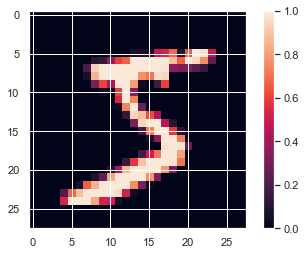

In [3]:
plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### Reducción de la imagen

Tensorflow tiene el método *tf.image.resize* que disminuye las imagenes a partir de los siguientes posibles criteros:

<ul>
<li><b>bilinear</b>: Bilinear interpolation. If antialias is true, becomes a hat/tent filter function with radius 1 when downsampling.</li>
<li><b>lanczos3</b>: Lanczos kernel with radius 3. High-quality practical filter but may have some ringing, especially on synthetic images.</li>
<li><b>lanczos5</b>: Lanczos kernel with radius 5. Very-high-quality filter but may have stronger ringing.</li>
<li><b>bicubic</b>: Cubic interpolant of Keys. Equivalent to Catmull-Rom kernel. Reasonably good quality and faster than Lanczos3Kernel, particularly when upsampling.</li>
<li><b>gaussian</b>: Gaussian kernel with radius 3, sigma = 1.5 / 3.0.</li>
<li><b>nearest</b>: Nearest neighbor interpolation. antialias has no effect when used with nearest neighbor interpolation.</li>
<li><b>area</b>: Anti-aliased resampling with area interpolation. antialias has no effect when used with area interpolation; it always anti-aliases.</li>
<li><b>mitchellcubic</b>: Mitchell-Netravali Cubic non-interpolating filter. For synthetic images (especially those lacking proper prefiltering), less ringing than Keys cubic kernel but less sharp.</li>
    
</ul>


Ejemplo de dicho preprocesamiento de reducción de datos se emplea a continuación con el método nearest y con el tamaño de imagen 8x8.

In [4]:
x_train_small = tf.image.resize(x_train, (8,8), method='nearest', preserve_aspect_ratio=True).numpy()
x_test_small = tf.image.resize(x_test, (8,8), method='nearest', preserve_aspect_ratio=True).numpy()

En este punto se tienen imagenes de tamaño 8x8 y se tienen que pasar como un estado de amplitud ya que $8x8 = 64$  y esto nos dará un vector de $2^6$ que recordando el valor 6 es el número de qubits a usar 

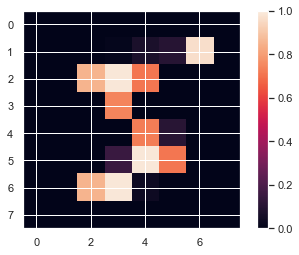

In [5]:
plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [6]:
x_train = x_train_small.reshape(len(x_train_small), 64)
x_test = x_test_small.reshape(len(x_test_small), 64)
x_train.shape,x_test.shape

((60000, 64), (10000, 64))

In [62]:
x_train_small[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.00428903],
        [0.0257342 ],
        [0.03717162],
        [0.35313038],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.31309941],
        [0.36170845],
        [0.26020134],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.27163876],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.26592005],
        [0.0386013 ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.05575743],
        [0.36170845],


## De imagen a qubits

Por las capacidades que actualmente se usa CPU para el diseño de circuitos cuánticos en Qiskit, no es posible ocupar todo el conjunto de imagenes, ocupando:

<ul>
    <li>Las 2000 primeras imagenes del conjunto de entrenamiento.</li>
    <li>Las primeras 2000 primeras imagenes dle conjunto de testeo.</li>    
</ul>

In [7]:
x_train = (x_train[:45])
x_test = (x_test[:20])

x_train.shape,x_test.shape

((45, 64), (20, 64))

Se obtiene un vector de tamaño 64x1 por cada imagen

In [8]:
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01176471, 0.07058824, 0.10196078, 0.96862745,
       0.        , 0.        , 0.        , 0.85882353, 0.99215686,
       0.71372549, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.74509804, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.72941176, 0.10588235, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.15294118, 0.99215686,
       0.71372549, 0.        , 0.        , 0.        , 0.        ,
       0.85882353, 0.99215686, 0.03529412, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

Se elimina las posibles imagenes que no tengan información, es decir, puros 0's

In [9]:
k = 0

while k < len(x_train):
  a = x_train[k].copy()
  if np.sum(a) == 0.:
    print(k,x_train[k])
    x_train = np.delete(x_train, k, axis=0)
    y_train = np.delete(y_train, k, axis=0)
    k -= 1
  k+=1

In [10]:
k = 0

while k < len(x_test):
  a = x_test[k].copy()
  if np.sum(a) == 0.:
    print(k,x_test[k])
    x_test = np.delete(x_test, k, axis=0)
    y_test = np.delete(y_test, k, axis=0)
    k -= 1
  k+=1


Ahora se aplicara una renormalización para poder interpretar un vector de estado para pdoer aplicarse en nuestro modelo de circuito cuántico

In [11]:
import cmath
def Normalize(row):
  suma = np.sqrt(np.sum(row**2))
  if suma == 0.:
    return 0.0
  row = row/suma
  return row


for i in range(len(x_train)):
    x_train[i] = Normalize(x_train[i])
    
for i in range(len(x_test)):
    x_test[i] = Normalize(x_test[i])
    
print("la suma de los estados de la imagen del conjunto de entrenamiento 0",np.sum(x_train[0]**2))

la suma de los estados de la imagen del conjunto de entrenamiento 0 0.9999999999999999


# Análisis y Diseño del Autoencoder

In [12]:
n=6
num_layers = 1
params = np.random.random(14*(num_layers))

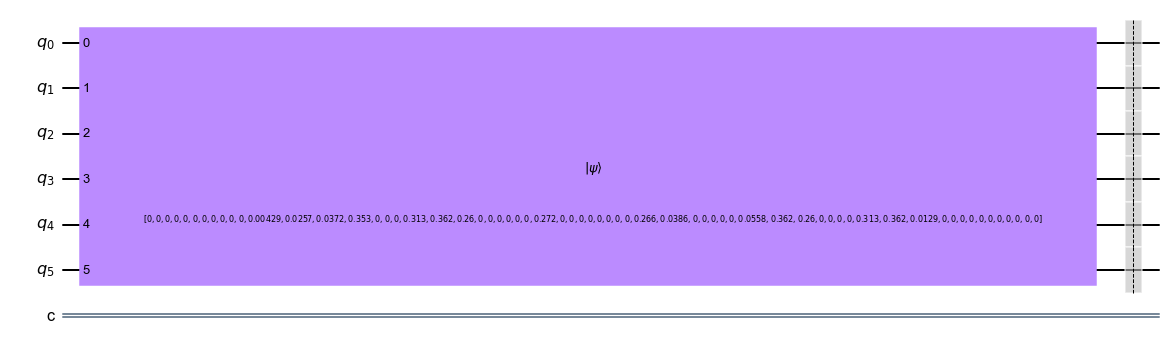

In [13]:
def input_data(n,inputs):
    circuit = QuantumCircuit(n,1)
    circuit.initialize(inputs,range(0,n,1))
    circuit.barrier()
    return circuit
input_data(n,x_train[0]).draw(output="mpl")

In [14]:
def vqc(n, num_layers,params):
    #Set the number of layers and qubits
    #ParameterVectors are initialized with a string identifier and an integer specifying the vector length
    
    
    parameters = ParameterVector('θ', 14*(num_layers))
    len_p = len(parameters)
    circuit = QuantumCircuit(n, 1)
    

    
    for layer in range(num_layers):
        for i in range(n):
            circuit.ry(parameters[(n*(layer))+i], i)
        circuit.barrier()

        circuit.cz(0,1)
        circuit.cz(0,2)
        circuit.cz(1,3)
        circuit.cz(0,4)
        circuit.cz(1,5)
        circuit.barrier()
        
        for i in range(n):
            circuit.ry(parameters[n*(layer+1)+i], i-n)
        circuit.barrier()
        
        circuit.cz(0,1)
        circuit.cz(0,3)
        circuit.cz(1,2)
        circuit.cz(0,5)
        circuit.cz(1,4)
        circuit.barrier()

        for i in range(2):
            circuit.ry(parameters[2*n*(layer+1)+i], i)
        circuit.barrier()
    
    params_dict = {}
    i = 0
    for p in parameters:
        params_dict[p] = params[i]
        i += 1
    #Assign parameters using the assign_parameters method
    circuit = circuit.assign_parameters(parameters = params_dict)
    return circuit

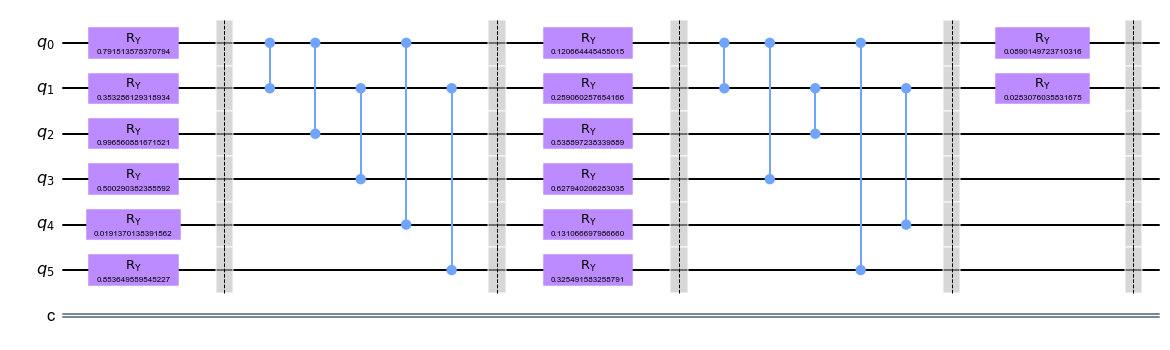

In [15]:
vqc(n,num_layers,params).draw(output="mpl")

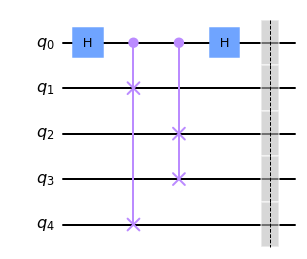

In [16]:
def swap_test(n):
    qubits_values = 2*n+1
    qc = QuantumCircuit(qubits_values)
    qc.h(0)
    for i in range(n):
        qc.cswap(0,i+1,2*n-i)
    qc.h(0)
    qc.barrier()
    return qc
swap_test(2).draw(output="mpl")

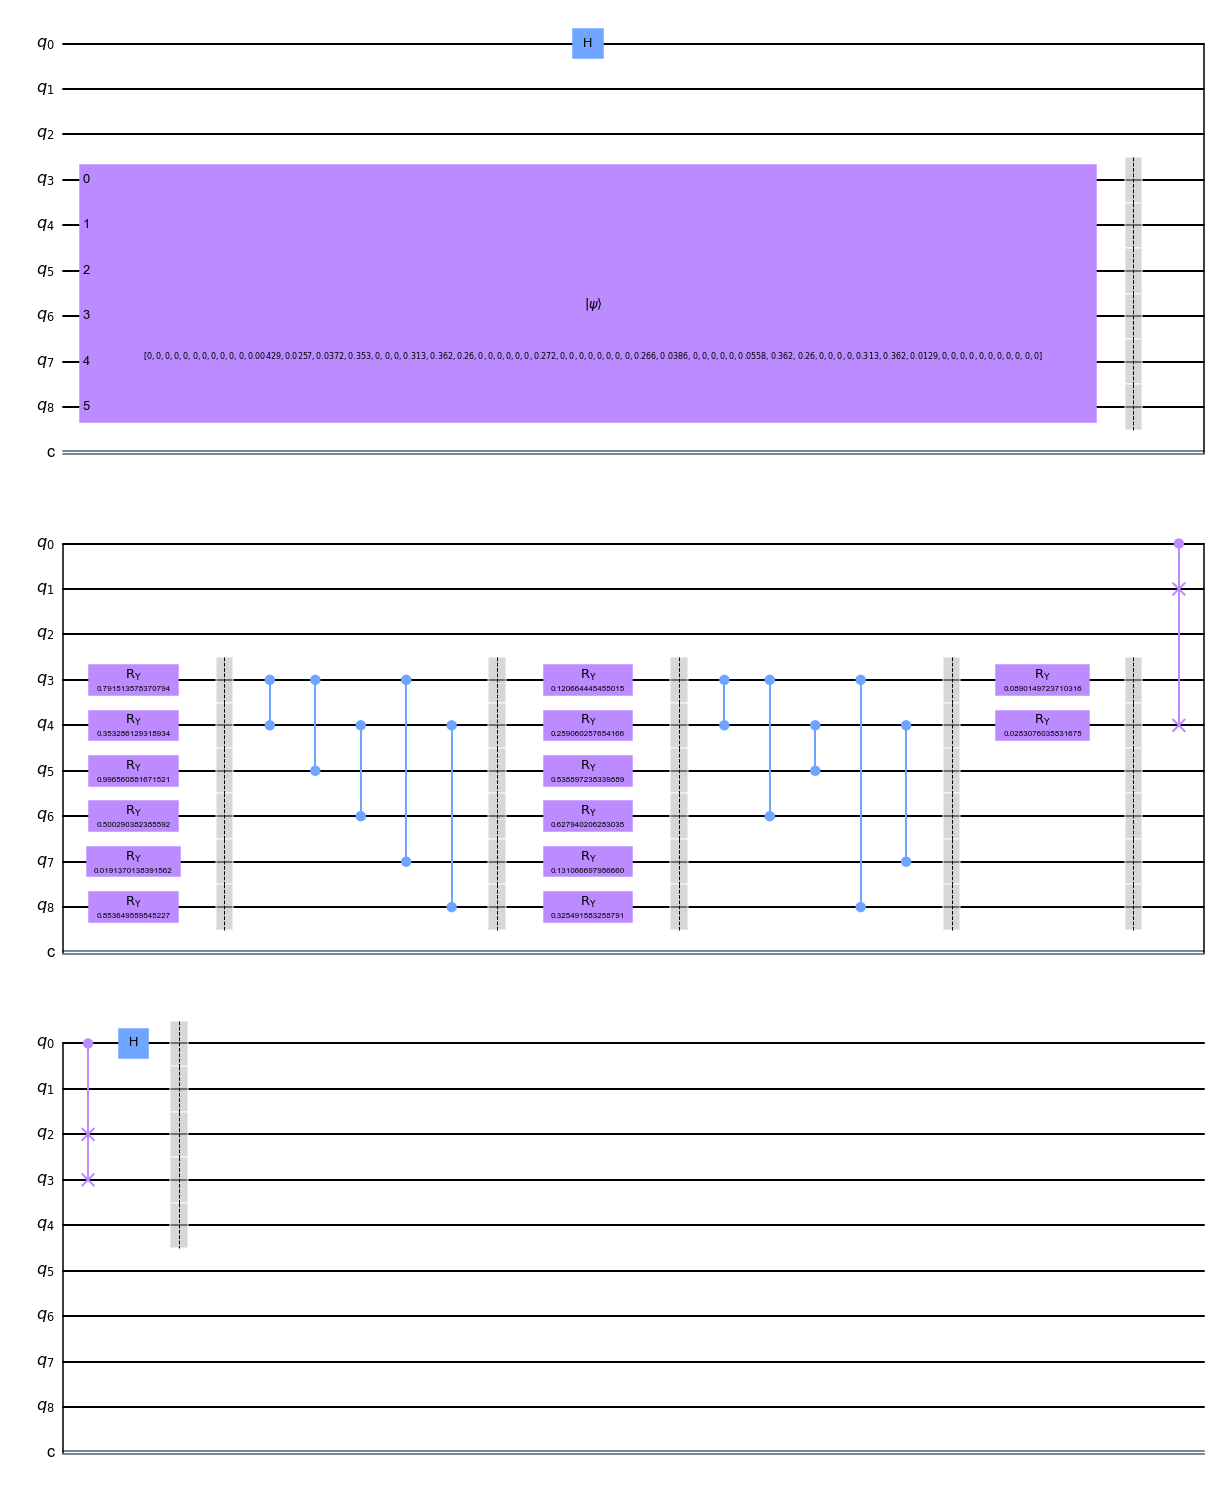

In [17]:
size_reduce = 2
circuit_init = input_data(n,x_train[0])
circuit_vqc = vqc(n,num_layers,params)
circuit_swap_test = swap_test(size_reduce)

circuit_full = QuantumCircuit(n+size_reduce+1,1)

circuit_full = circuit_full.compose(circuit_init,[i for i in range(size_reduce+1,n+size_reduce+1)])
circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(size_reduce+1,n+size_reduce+1)])
circuit_full = circuit_full.compose(circuit_swap_test,[i for i in range(2*size_reduce+1)])
circuit_full.draw(output="mpl")

In [18]:
from scipy.optimize import minimize ## need the mthod minimize of scipy.optimize module

def calc_cost(circuit_value):
    diff = sum(circuit_value)       ## calculates the sum of squares 
    mod_abs = diff.real**2 + diff.imag**2   ## of mod of difference between corresponding elements 
    cost = np.sum(mod_abs)                  ## of real_value and circuit_value
    return cost                             ## returns the cost

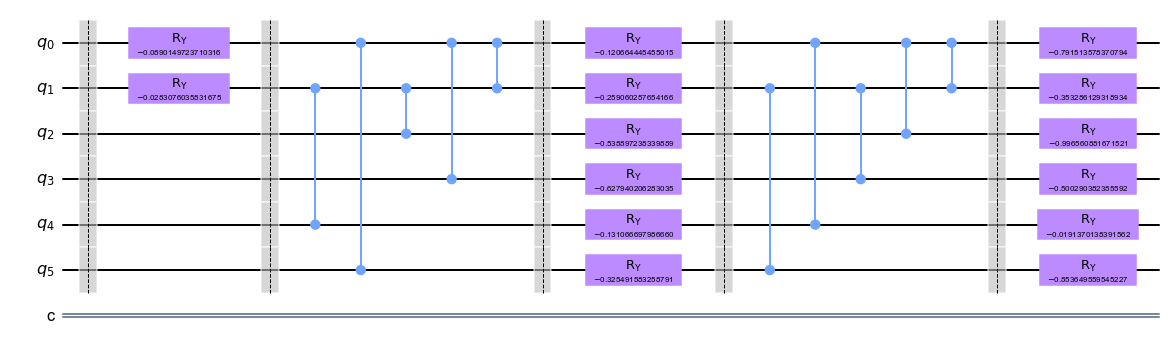

In [19]:
vqc(n,num_layers,params).inverse().draw(output = "mpl")

## Coder 

In [20]:
def objective_function(params):
    compress = []
    for i in range(len(x_train)):
        circuit_init = input_data(n,x_train[i])
        circuit_vqc = vqc(n,num_layers,params)
        circuit_swap_test = swap_test(size_reduce)

        circuit_full = QuantumCircuit(n+size_reduce+1,1)

        circuit_full = circuit_full.compose(circuit_init,[i for i in range(size_reduce+1,n+size_reduce+1)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(size_reduce+1,n+size_reduce+1)])
        circuit_full = circuit_full.compose(circuit_swap_test,[i for i in range(2*size_reduce+1)])
        circuit_full.measure(0, 0)
        #qc.draw()
        job = execute( circuit_full, Aer.get_backend('qasm_simulator') )
        result = job.result().get_counts()
        
        try:
            compress.append(result['1']/1024)
        except:
            compress.append(0)
        cost = calc_cost(compress)
    return cost

for i in range(50):    
    minimum = minimize(objective_function, params, method='COBYLA', tol=1e-6)
    params = minimum.x
    print(" cost: ",objective_function(params))
    print(params)

 cost:  159.16877841949463
[-0.35996672 -0.6142227   1.00213538  0.82621409 -0.69650229 -0.57613705
 -0.03346445 -0.45223117  1.21324029  1.27251577  1.19818619  1.29954105
  0.6894639   0.36259788]
 cost:  150.30185317993164
[-0.72686938 -0.63615459  1.08545413  0.94176493 -0.74245357 -0.636906
 -0.04525735 -0.32555462  0.9908163   1.09357592  2.09250131  1.34065287
  0.63497612  0.43063862]
 cost:  142.90054416656494
[-0.74182099 -0.59515172  1.10485837  1.08835998 -0.87260317 -0.66407977
 -0.01671255 -0.12558169  1.19570189  1.19777227  2.07827608  1.38501278
  0.58451428  0.72452495]
 cost:  145.29194736480713
[-0.97594424 -0.85179044  1.04140975  1.12300449 -1.02401285 -0.74828594
 -0.2494897  -0.28090439  1.14717436  1.18717241  1.95976066  1.45969299
  0.34840682  0.58890371]
 cost:  134.46033096313477
[-1.12948058 -0.5697726   1.05253151  1.31402891 -0.79416521 -0.92110538
 -0.09841157 -0.04298124  0.98050335  1.1746056   1.92370307  1.21425265
  0.43679503  0.6570102 ]
 cost: 

 cost:  93.545166015625
[-1.78037789  0.17592175 -0.25582107  2.00347951 -1.5273255  -1.61388582
 -0.34182386 -0.06801629  1.57162717 12.5376522   2.75725109 12.28443478
  0.6578865   1.29203929]
 cost:  92.22751235961914
[-1.81071334  0.28411161 -0.32784511  1.99640043 -1.50308857 -1.63941013
 -0.3255458  -0.05383399  1.58385867 12.57086057  2.82757831 12.28889075
  0.68716383  1.27089676]
 cost:  93.14888858795166
[-1.79317927  0.27296524 -0.32429109  1.99324287 -1.51415846 -1.63731962
 -0.32084716 -0.05908377  1.59783947 12.54700606  2.8363153  12.29012653
  0.7262403   1.26246359]
 cost:  92.15250015258789
[-1.80292639  0.2255938  -0.27720897  2.00265804 -1.52829388 -1.43656055
 -0.15576932 -0.12600313  1.5734102  12.53278008  2.81457128 12.27000978
  0.70116672  1.2186535 ]
 cost:  92.05877780914307
[-1.86705474  0.21130914 -0.3090545   1.94858891 -1.57590704 -1.48493848
 -0.17899421 -0.14847343  1.56789399 12.52174068  2.78530124 12.23758034
  0.67678226  1.19539335]
 cost:  91.7

In [122]:
def compress_result(params):
    reduce = []
    for i in range(len(x_test)):
        circuit_init = input_data(n,x_test[i])
        circuit_vqc = vqc(n,num_layers,params)

        circuit_full = QuantumCircuit(n,n-size_reduce)

        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        len_cf = len(circuit_full)
        for i in range(n-size_reduce):
            circuit_full.measure(size_reduce+i, i)
        job = execute( circuit_full, Aer.get_backend('qasm_simulator') )
        result = job.result().get_counts()
        probs = {k: np.sqrt(v / 1024) for k, v in result.items()}
        reduce.append(probs)
        
    return reduce
        
reduce_img =compress_result(params)


In [123]:
test_reduce = []
for i in reduce_img:
    index_image = []
    for j in range(16):
        bin_index = bin(j)[2:]
        while len(bin_index) <4:
            bin_index = '0'+bin_index 
        try:   
            index_image.append(i[bin_index])
        except:
            index_image.append(0)
    
    test_reduce.append(np.array(index_image))

<Figure size 432x288 with 0 Axes>

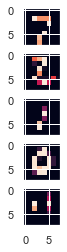

In [124]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(5,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(x_test[0].reshape(8,8))
axarr[1].imshow(x_test[1].reshape(8,8))
axarr[2].imshow(x_test[2].reshape(8,8))
axarr[3].imshow(x_test[3].reshape(8,8))
axarr[4].imshow(x_test[4].reshape(8,8))

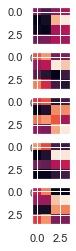

In [125]:

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(5,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(test_reduce[0].reshape(4,4))
axarr[1].imshow(test_reduce[1].reshape(4,4))
axarr[2].imshow(test_reduce[2].reshape(4,4))
axarr[3].imshow(test_reduce[3].reshape(4,4))
axarr[4].imshow(test_reduce[4].reshape(4,4))

In [135]:
def decoder_result(params):
    reduce = []
    for i in range(len(x_test)):
        circuit_init = input_data(n,x_test[i])
        circuit_vqc = vqc(n,num_layers,params).inverse()

        circuit_full = QuantumCircuit(n,n)

        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        job = execute( circuit_full, Aer.get_backend('statevector_simulator') )
        result = job.result().get_statevector()
        reduce.append(result)
    return reduce
        
decoder =decoder_result(params)
decoder

[array([ 0.05585678+0.j, -0.08407152+0.j, -0.02934644+0.j, -0.14434268+0.j,
        -0.08516637+0.j,  0.01140421+0.j, -0.18080312+0.j,  0.1136341 +0.j,
         0.09348529+0.j, -0.28215693+0.j,  0.14477127+0.j,  0.10794261+0.j,
        -0.0136083 +0.j, -0.09369615+0.j, -0.08037104+0.j, -0.06992333+0.j,
         0.13978005+0.j,  0.16526017+0.j, -0.05020202+0.j, -0.06514244+0.j,
         0.10910272+0.j,  0.15056371+0.j, -0.0515702 +0.j,  0.14265981+0.j,
         0.0689967 +0.j, -0.15292695+0.j,  0.22176006+0.j,  0.27133958+0.j,
         0.07764425+0.j, -0.00729368+0.j, -0.05182424+0.j, -0.075824  +0.j,
         0.18151602+0.j,  0.1948021 +0.j,  0.13761653+0.j, -0.12364152+0.j,
         0.0302415 +0.j,  0.13957743+0.j,  0.22020822+0.j, -0.00963958+0.j,
         0.03734734+0.j, -0.09765728+0.j,  0.03880226+0.j,  0.14715861+0.j,
        -0.05319496+0.j,  0.16984031+0.j, -0.02198835+0.j,  0.09599182+0.j,
         0.17308421+0.j,  0.08939279+0.j,  0.04468383+0.j, -0.28326894+0.j,
        -0.0

<Figure size 432x288 with 0 Axes>

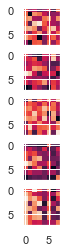

In [146]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(5,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(decoder[0].real.reshape(8,8))
axarr[1].imshow(decoder[1].real.reshape(8,8))
axarr[2].imshow(decoder[2].real.reshape(8,8))
axarr[3].imshow(decoder[3].real.reshape(8,8))
axarr[4].imshow(decoder[4].real.reshape(8,8))

In [154]:
input_data(n,x_test[0])


1